In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install truecase

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re

import spacy, re
from truecase import get_true_case
import nltk

##Data preprocessing

<h3>Stage one: exploring the data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/NLPmodel/2020-12-31-DynamicallyGeneratedHateDataset-entries-v0.1.csv")
data.head(5)

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
2,3,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm
3,4,10003,It was a better world when women dare not ques...,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3
4,5,10004,I don't work this hard so that those immigrant...,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm


The above dataframe shows the 11 columns present in the dataset which each describes a charactirsitics in the data. Since we dont need any of them except the text and the label columns so I will drop the rest.

In [ ]:
data = data.drop(['Unnamed: 0','id','type','model_wrong','db.model_preds','status','round','split','annotator'], axis=1)
data

As we can see the shape now is 40623 rows × 2 columns which mean 40k datapoint with 2 columns, the columns are text and label.

Below are the only two labels in the dataset, we will be using them to detect hate in news.

In [ ]:
data.label.unique()

array(['hate', 'nothate'], dtype=object)

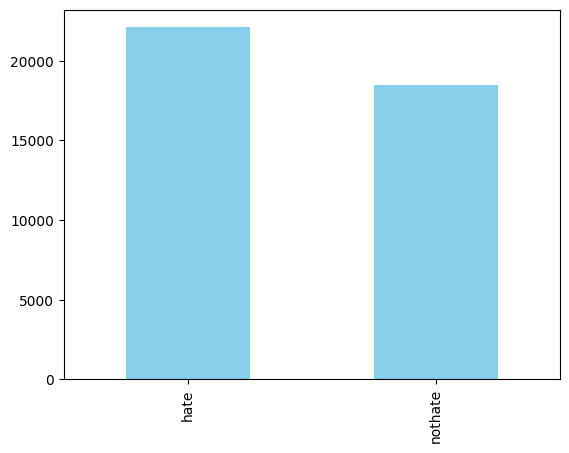

In [ ]:
count = data['label'].value_counts().plot(kind="bar", color="skyblue")

The above figure shows that the dataset is almost balanced which means any model trained on it won't be biased towards a specif class.

Checking if there are any null values

In [ ]:
print("Total Null values count: ",
      data.isnull().sum())

Total Null values count:  text     0
label    0
dtype: int64


the above output shows that the there are no null values in the two columns we need, the ID and the text columns.

Visualizing the class distribution

In [ ]:
def score(score):
    if score == 'nothate':
        return "nothate"
    if score == 'hate':
        return "hate"

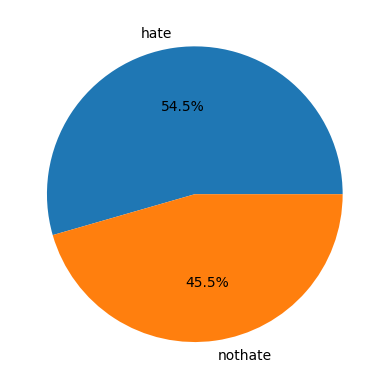

In [ ]:
data['label'] = data['label'].apply(score)
plt.pie(data['label'].value_counts(), labels=data['label'].unique().tolist(), autopct='%1.1f%%')
plt.show()

In [ ]:
data.duplicated().sum()

In [ ]:
data.drop_duplicates(subset=None, inplace=True)

# Text preprocessing

From exploring the data, it looks like the data is almost clean and it is doesn't have any special characters or urls but I had to make sure by performing data cleaning

First I will be lowering the case in the datase, then expand the contractions, then remove digits & punctuations. Also I will do other operations like removal of stop words, puncutaction, special characters, urls. then Tokenization, stemming, lemmatization, correcting errors (correcting spelling mistakes).

<h5>Lowercasing

In [ ]:
data['text_lowered'] = data["text"].str.lower()
data.head()

,text,label,text_lowered
0,It should be legal for a husband to rape his wife,hate,it should be legal for a husband to rape his wife
1,dalits are lowlife scum,hate,dalits are lowlife scum
2,dalits are lowlives,hate,dalits are lowlives
3,It was a better world when women dare not ques...,hate,it was a better world when women dare not ques...
4,I don't work this hard so that those immigrant...,hate,i don't work this hard so that those immigrant...


**Contractions**

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
data['text']=data['text'].apply(lambda x:expand_contractions(x))

In [ ]:
data['text'] #it worked heheheheheh

0        It should be legal for a husband to rape his wife
1                                  dalits are lowlife scum
2                                      dalits are lowlives
3        It was a better world when women dare not ques...
4        I do not work this hard so that those immigran...
                               ...                        
40618    we should forcibly remove all the foreigners f...
40619    we should forcibly remove all the immigrants f...
40620                 dalits are unworthy of the Gods love
40621                                 dalits are worthless
40622         dalits are deserves to be treated as lowlife
Name: text, Length: 40623, dtype: object

**remove words or parts of words containing numbers**

In [ ]:
data['cleaned']=data['text'].apply(lambda x: re.sub('\w*\d\w*','', x))

**remove any punctuation**

In [ ]:
data['cleaned']=data['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

**Removing extra spaces**

In [ ]:
data['cleaned']=data['cleaned'].apply(lambda x: re.sub(' +',' ',x))

Text after cleaning

In [ ]:
for index,text in enumerate(data['cleaned'][40:55]):
  print('text %d:\n'%(index+1),text)

text 1:
 pear is not tasty
text 2:
 blonde ladies are fucing smart
text 3:
 blonde people are not smart
text 4:
 Arabs are terrorists
text 5:
 Terrorists must be Muslims
text 6:
 Terrorists must be Muslim rats
text 7:
 Terrorists are always Muslim but never white
text 8:
 Terrorists are always fucking Muslim but never white
text 9:
 veiled women are dumb
text 10:
 blonde people suck
text 11:
 Blonde people are bad
text 12:
 Blonde women are sick
text 13:
 Blonde men are sick
text 14:
 immigrants are like animals they dont belong to this world
text 15:
 Indian people are not smart


# Model

#Implementing BERT with new data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])


In [ ]:
data

,text,label,text_lowered,cleaned
0,It should be legal for a husband to rape his wife,0,it should be legal for a husband to rape his wife,It should be legal for a husband to rape his wife
1,dalits are lowlife scum,0,dalits are lowlife scum,dalits are lowlife scum
2,dalits are lowlives,0,dalits are lowlives,dalits are lowlives
3,It was a better world when women dare not ques...,0,it was a better world when women dare not ques...,It was a better world when women dare not ques...
4,I do not work this hard so that those immigran...,0,i don't work this hard so that those immigrant...,I do not work this hard so that those immigran...
...,...,...,...,...
40618,we should forcibly remove all the foreigners f...,0,we should forcibly remove all the foreigners f...,we should forcibly remove all the foreigners f...
40619,we should forcibly remove all the immigrants f...,0,we should forcibly remove all the immigrants f...,we should forcibly remove all the immigrants f...
40620,dalits are unworthy of the Gods love,0,dalits are unworthy of the gods love,dalits are unworthy of the Gods love
40621,dalits are worthless,0,dalits are worthless,dalits are worthless


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    data['cleaned'],  # Input features
    data['label'],                     # Target variable
    stratify=data['label'],             # Preserve class distribution in the splits
    test_size=0.2                              # 20% for testing (adjust as needed)
)

# Further splitting training set into training and validation sets
X_test ,X_valid, y_test, y_valid = train_test_split(
    X_temp,                                   # Input features (from previous split)
    y_temp,                                   # Target variable (from previous split)
    stratify=y_temp,                          # Preserve class distribution in the splits
    test_size=0.1                              # 10% for validation (adjust as needed)
)

In [ ]:
!pip install tensorflow_text

In [ ]:
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import load_model
import tensorflow_text as text

In [ ]:
bert_preprocess = hub.KerasLayer(("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"))
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
x = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
x = tf.keras.layers.Dense(units=512)(x)
x = tf.keras.layers.Dense(units=256)(x)
x = tf.keras.layers.Dense(units=128)(x)
x = tf.keras.layers.Dense(units=64)(x)
x = tf.keras.layers.Dense(units=1, activation='sigmoid', name="output")(x)


# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [x])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
import keras

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
]
opt = keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

In [ ]:
history = model.fit(X_train, y_train, validation_data= [X_valid,y_valid],epochs=3)

Epoch 1/3
1016/1016 [==============================] - 377s 347ms/step - loss: 0.6768 - accuracy: 0.5895 - val_loss: 0.6348 - val_accuracy: 0.6384
Epoch 2/3
1016/1016 [==============================] - 355s 350ms/step - loss: 0.6529 - accuracy: 0.6156 - val_loss: 0.6268 - val_accuracy: 0.6494
Epoch 3/3
1016/1016 [==============================] - 354s 348ms/step - loss: 0.6464 - accuracy: 0.6233 - val_loss: 0.6472 - val_accuracy: 0.6187


#Model evaluation

In [ ]:
model.evaluate(X_test, y_test)

229/229 [==============================] - 79s 343ms/step - loss: 0.6493 - accuracy: 0.6183


[0.649296760559082, 0.6182987093925476]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

229/229 [==============================] - 77s 332ms/step


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
y_pred_normalized = scaler.fit_transform(np.array(y_predicted).reshape(-1, 1))
threshold = 0.5
y_pred_binary = np.where(y_pred_normalized > threshold, 1, 0)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred_binary)
cm

array([[2314, 1668],
       [1043, 2287]])

Text(50.722222222222214, 0.5, 'Truth')

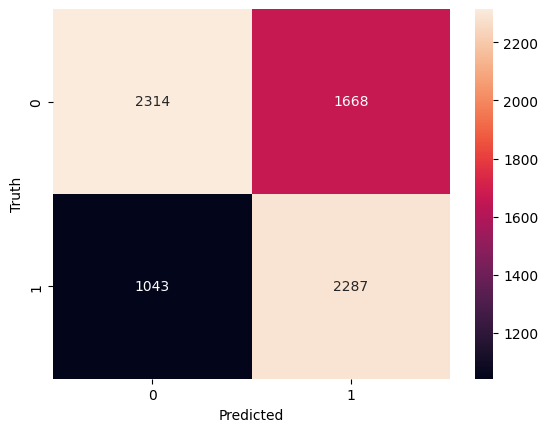

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.69      0.58      0.63      3982
           1       0.58      0.69      0.63      3330

    accuracy                           0.63      7312
   macro avg       0.63      0.63      0.63      7312
weighted avg       0.64      0.63      0.63      7312



In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(4, 2))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

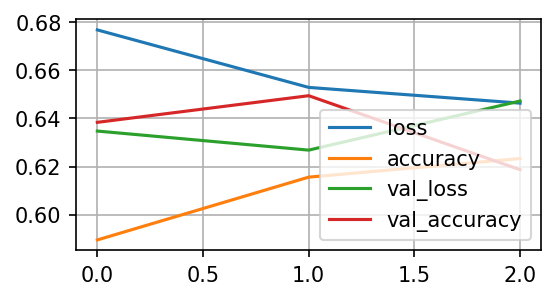

In [ ]:
plot2(history)

# prediction

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

def classify_text(sentence):
    # Load the BERT preprocessor
    bert_preprocess = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

    # Preprocess the input sentence
    preprocessed_sentence = bert_preprocess([sentence])

    # Load the trained BERT model
    bert_encoder = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3")

    # Use the BERT model for prediction
    outputs = bert_encoder(preprocessed_sentence)
    predicted_prob = tf.squeeze(outputs['pooled_output'])[0]
    predicted_label = "hate" if predicted_prob >= 0.5 else "not hate"

    return predicted_label

In [ ]:
# Example usage
sentence = "I love this movie!"
classification = classify_text(sentence)
print(f"The text is classified as: {classification}")

The text is classified as: not hate
